# Extraindo os dados

In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador
import numpy as np

SEED = 158020
np.random.seed(SEED)

dados["modelo"] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,19
1,40557.96,1,20,12622.05362,22
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,4
4,117384.68,1,4,12770.11290,4


# Analisando hiperparâmetros

## Uma dimensão

In [3]:
from sklearn.model_selection import GroupKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate


def decision_tree_tests_pipeline(
    max_depth, x, y, groups, n_splits=10, SEED=np.random.seed
):
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=n_splits)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(
        modelo, x, y, cv=cv, groups=groups, return_train_score=True
    )
    train_score = results["train_score"].mean() * 100
    test_score = results["test_score"].mean() * 100
    tabela = [max_depth, train_score, test_score]
    return tabela

In [4]:
x = dados[["preco", "idade_do_modelo", "km_por_ano"]]
y = dados["vendido"]
groups = dados["modelo"]

results = [
    decision_tree_tests_pipeline(max_depth, x, y, groups, n_splits=10, SEED=SEED)
    for max_depth in range(1, 33)
]
df_results = pd.DataFrame(results, columns=["max_depth", "train", "test"])
df_results.head()

,max_depth,train,test
0,1,75.791256,75.790527
1,2,75.791256,75.790527
2,3,78.755626,78.686402
3,4,78.791207,78.666231
4,5,78.953333,78.667173


In [5]:
import plotly.express as px

fig = px.line(df_results, x="max_depth", y=["train", "test"])
fig.show()

## Duas dimensões

In [6]:
def decision_tree_tests_pipeline(
    max_depth, min_samples_leaf, x, y, groups, n_splits=10, SEED=np.random.seed
):
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=n_splits)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    results = cross_validate(
        modelo, x, y, cv=cv, groups=groups, return_train_score=True
    )
    train_score = results["train_score"].mean() * 100
    test_score = results["test_score"].mean() * 100
    tabela = [max_depth, min_samples_leaf, train_score, test_score]
    return tabela

def get_dataframe():
    results = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            results.append(
                decision_tree_tests_pipeline(
                    max_depth, min_samples_leaf, x, y, groups, n_splits=10, SEED=SEED
                )
            )
    df_results = pd.DataFrame(results, columns=["max_depth", "min_samples_leaf", "train", "test"])
    return df_results

In [7]:
df_results = get_dataframe()
df_results.head()

,max_depth,min_samples_leaf,train,test
0,1,32,75.791256,75.790527
1,1,64,75.791256,75.790527
2,1,128,75.791256,75.790527
3,1,256,75.791256,75.790527
4,2,32,75.791256,75.790527


In [8]:
df_results.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,64,78.752296,78.696514
15,4,256,78.752296,78.696514
14,4,128,78.752296,78.696514
8,3,32,78.752296,78.696514
9,3,64,78.752296,78.696514


In [9]:
import plotly.graph_objects as go

corr_results = df_results.corr()

fig = go.Figure(data=go.Heatmap(z=corr_results.values, x=corr_results.columns, y=corr_results.columns))
fig.show()

# Implementando GridSearchCV

In [10]:
from sklearn.model_selection import GridSearchCV

np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth": [1, 2, 3],
    "min_samples_leaf": [32, 64, 128, 256],
    "min_samples_split": [32, 64, 128, 256],
    "criterion": ["gini", "entropy"],
}

busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv=GroupKFold(n_splits=10))
busca.fit(x, y, groups=groups)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003656,0.001164,0.000842,0.000163,gini,1,32,32,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.778449,...,0.787879,0.756923,0.733064,0.777557,0.746224,0.735926,0.739981,0.757905,0.018861,33
1,0.002811,0.000093,0.000571,0.000103,gini,1,32,64,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.778449,...,0.787879,0.756923,0.733064,0.777557,0.746224,0.735926,0.739981,0.757905,0.018861,33
2,0.002804,0.000076,0.000580,0.000083,gini,1,32,128,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.778449,...,0.787879,0.756923,0.733064,0.777557,0.746224,0.735926,0.739981,0.757905,0.018861,33
3,0.002809,0.000115,0.000534,0.000013,gini,1,32,256,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.778449,...,0.787879,0.756923,0.733064,0.777557,0.746224,0.735926,0.739981,0.757905,0.018861,33
4,0.002779,0.000065,0.000558,0.000053,gini,1,64,32,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.778449,...,0.787879,0.756923,0.733064,0.777557,0.746224,0.735926,0.739981,0.757905,0.018861,33


In [11]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.69651370754656


In [12]:
busca.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

## Evitar a abordagem abaixo (Non-Nested Cross-Validation):

In [13]:
from sklearn.metrics import accuracy_score

melhor_modelo = busca.best_estimator_
predicao = melhor_modelo.predict(x)

accuracy = accuracy_score(y, predicao) * 100
print(f"A acurácia foi {accuracy:.2f}%")

A acurácia foi 78.75%


Esse resultado é otimista pois está sujeito ao que é chamado de "leakage" de informação. Isso pode levar ao _overfitting_ visto que o modelo está enviesado pelo mesmo conjunto de dados que foi utilizado para a otimização de hiperparâmetros.

Para resolver esse problema, deve ser realizado o que é chamado de **Nested Cross-Validation**

## Nested Cross-Validation

Em Nested Cross-Validation, temos um loop externo e um loop interno. No loop externo, os dados são divididos em conjuntos de treinamento e teste (conjunto de teste para avaliação). No loop interno, que é tipicamente executado por técnicas como GridSearchCV, o conjunto de treinamento é dividido ainda mais em conjuntos de treinamento e validação (conjunto de validação para ajuste de parâmetros).

O modelo é treinado no conjunto de treinamento interno e depois validado no conjunto de validação interno para selecionar os melhores hiperparâmetros. Este processo é repetido para cada dobra externa, garantindo que o modelo seja treinado e avaliado em diferentes subconjuntos de dados. Finalmente, o desempenho do modelo é avaliado no conjunto de teste externo.

In [16]:
# Contém um bug quando utilizado GroupKFold

from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x, y, cv=GroupKFold(n_splits=10), groups=groups)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/leandrosouza/workspace/machine-learning-validacao/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/leandrosouza/workspace/machine-learning-validacao/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leandrosouza/workspace/machine-learning-validacao/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py", line 970, in fit
    self._run_search(evaluate_candidates)
  File "/Users/leandrosouza/workspace/machine-learning-validacao/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py", line 1527, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/Users/leandrosouza/workspace/machine-learning-validacao/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py", line 928, in evaluate_candidates
    for (cand_idx, parameters), (split_idx, (train, test)) in product(
                                                              ^^^^^^^^
  File "/Users/leandrosouza/workspace/machine-learning-validacao/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py", line 377, in split
    for train, test in super().split(X, y, groups):
  File "/Users/leandrosouza/workspace/machine-learning-validacao/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py", line 108, in split
    for test_index in self._iter_test_masks(X, y, groups):
  File "/Users/leandrosouza/workspace/machine-learning-validacao/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py", line 120, in _iter_test_masks
    for test_index in self._iter_test_indices(X, y, groups):
  File "/Users/leandrosouza/workspace/machine-learning-validacao/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py", line 563, in _iter_test_indices
    raise ValueError("The 'groups' parameter should not be None.")
ValueError: The 'groups' parameter should not be None.


In [17]:
from sklearn.model_selection import KFold

np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth": [1, 2, 3],
    "min_samples_leaf": [32, 64, 128, 256],
    "min_samples_split": [32, 64, 128, 256],
    "criterion": ["gini", "entropy"],
}

busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv=KFold(n_splits=5, shuffle=True))
busca.fit(x, y)
resultados = pd.DataFrame(busca.cv_results_)

In [18]:
scores = cross_val_score(busca, x, y, cv=KFold(n_splits=5, shuffle=True))

In [19]:
media = scores.mean() * 100
desvio_padrao = scores.std() * 100
print(f"A acurácia foi {media:.2f}% +- {desvio_padrao:.2f}%")

A acurácia foi 78.71% +- 0.96%


In [23]:
busca.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 256,
 'min_samples_split': 32}

In [20]:
busca.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=256, min_samples_split=32)

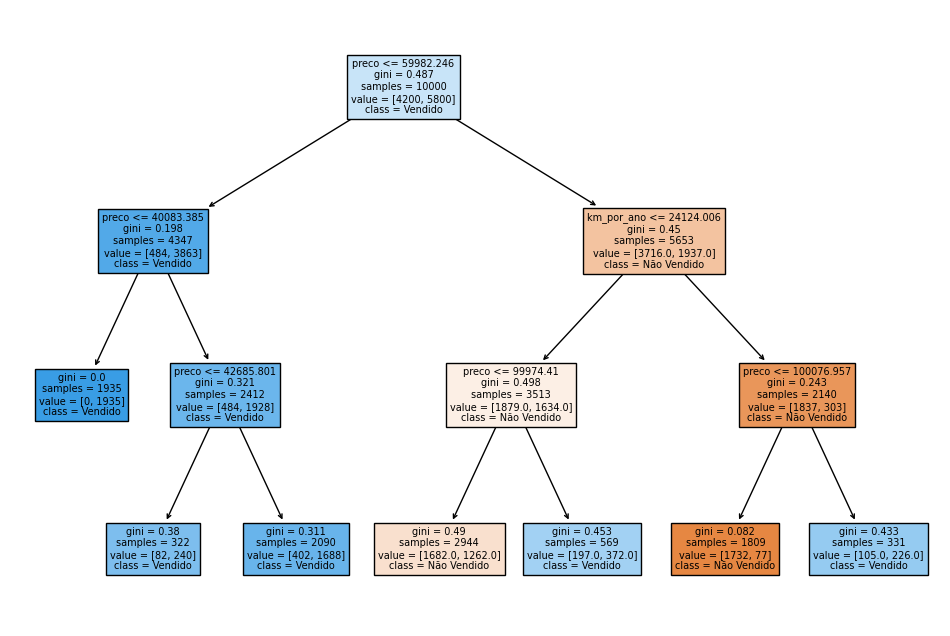

In [22]:
from sklearn import tree
import matplotlib.pyplot as plt

# Get the best decision tree model
best_model = busca.best_estimator_

# Plot the decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(best_model, feature_names=x.columns, class_names=["Não Vendido", "Vendido"], filled=True)
plt.show()


# Implementando RandomizedSearchCV

In [24]:
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth": [1, 2, 3],
    "min_samples_leaf": [32, 64, 128, 256],
    "min_samples_split": [32, 64, 128, 256],
    "criterion": ["gini", "entropy"],
}

busca = RandomizedSearchCV(DecisionTreeClassifier(), espaco_de_parametros, n_iter=16, cv=KFold(n_splits=5, shuffle=True))
busca.fit(x, y)
resultados = pd.DataFrame(busca.cv_results_)
scores = cross_val_score(busca, x, y, cv=KFold(n_splits=5, shuffle=True))
media = scores.mean() * 100
desvio_padrao = scores.std() * 100
melhor_modelo = busca.best_estimator_
print(f"A acurácia foi {media:.2f}% +- {desvio_padrao:.2f}%")
print(melhor_modelo)

A acurácia foi 78.70% +- 0.94%
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=32,
                       min_samples_split=32)


## Customizando o espaço de hiperparâmetros

In [25]:
from scipy.stats import randint

np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth": [1, 2, 3, 5, 10, 20, 30, None],
    "min_samples_leaf": randint(32, 128),
    "min_samples_split": randint(32, 128),
    "criterion": ["gini", "entropy"],
}

busca = RandomizedSearchCV(DecisionTreeClassifier(), espaco_de_parametros, n_iter=16, cv=KFold(n_splits=5, shuffle=True))
busca.fit(x, y)
resultados = pd.DataFrame(busca.cv_results_)
scores = cross_val_score(busca, x, y, cv=KFold(n_splits=5, shuffle=True))
media = scores.mean() * 100
desvio_padrao = scores.std() * 100
melhor_modelo = busca.best_estimator_
print(f"A acurácia foi {media:.2f}% +- {desvio_padrao:.2f}%")
print(melhor_modelo)

A acurácia foi 78.46% +- 1.24%
DecisionTreeClassifier(max_depth=3, min_samples_leaf=48, min_samples_split=74)


# Caso não seja possível utilizar cross validation

## Proporção entre os dados
- Treino 0.6
- Teste 0.2
- Validação 0.2

In [26]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

treino_proporcao = 0.6
teste_proporcao = 0.2
validacao_proporcao = 0.2

np.random.seed(SEED)

x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x, y, test_size=validacao_proporcao, stratify=y)

split = StratifiedShuffleSplit(n_splits=1, test_size=(teste_proporcao / (treino_proporcao + teste_proporcao)))

espaco_de_parametros = {
    "max_depth": [1, 2, 3, 5, 10, 20, 30, None],
    "min_samples_leaf": randint(32, 128),
    "min_samples_split": randint(32, 128),
    "criterion": ["gini", "entropy"],
}

busca = RandomizedSearchCV(DecisionTreeClassifier(), espaco_de_parametros, n_iter=16, cv=split)
busca.fit(x_treino_teste, y_treino_teste)
resultados = pd.DataFrame(busca.cv_results_)
scores = cross_val_score(busca, x_treino_teste, y_treino_teste, cv=split)
scores

array([0.783])